In [21]:
!pip install emoji -q
!python -m spacy download ru_core_news_sm -q

/Users/d.kulemin/Projects/dls_ecomtech_nlp_competition/.venv/bin/python: No module named spacy


In [33]:
from collections import defaultdict
import copy
import pathlib

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn
from tqdm.notebook import tqdm
from transformers import T5ForConditionalGeneration, T5Tokenizer
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
import transformers

%matplotlib inline

In [3]:
BACKBONE_NAME = "DeepPavlov/rubert-base-cased"
SUBMISSION_NAME = "rubert_base_cased"
NUM_LABELS = 50
BATCH_SIZE = 16
MAX_LEN = 256
RANDOM_STATE = 42
EPOCHS = 100
ROOT_DIR = pathlib.Path().absolute()

parser = spacy.load(
    'ru_core_news_sm',
    disable=["parser", "ner"],
)
tqdm.pandas()

### DATA PREP

In [2]:
train_df = pd.read_csv("data/train.csv")

In [5]:
trend_cnts = train_df.iloc[:, 5:].sum(axis=0, numeric_only=True)

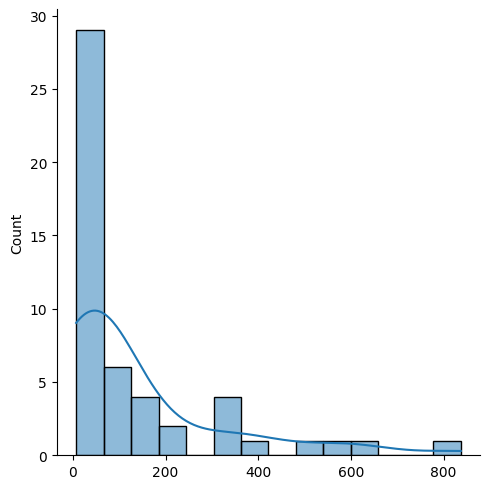

In [6]:
sns.displot(trend_cnts.values, kde=True)

In [8]:
trend_cnts.sort_values(ascending=True)

trend_id_res46      7
trend_id_res17      9
trend_id_res24     10
trend_id_res9      10
trend_id_res34     11
trend_id_res45     12
trend_id_res49     12
trend_id_res25     13
trend_id_res32     13
trend_id_res41     21
trend_id_res6      21
trend_id_res22     25
trend_id_res26     27
trend_id_res44     27
trend_id_res38     28
trend_id_res33     28
trend_id_res48     29
trend_id_res47     31
trend_id_res13     34
trend_id_res7      35
trend_id_res42     35
trend_id_res39     44
trend_id_res43     44
trend_id_res37     46
trend_id_res31     50
trend_id_res5      52
trend_id_res35     58
trend_id_res29     61
trend_id_res23     65
trend_id_res40     72
trend_id_res14     73
trend_id_res15     81
trend_id_res10     96
trend_id_res21     99
trend_id_res11    108
trend_id_res4     126
trend_id_res20    132
trend_id_res8     140
trend_id_res36    167
trend_id_res16    191
trend_id_res18    231
trend_id_res30    306
trend_id_res1     347
trend_id_res19    360
trend_id_res3     361
trend_id_r

In [9]:
uniques_df = train_df.groupby('text')['index'].nunique()

In [11]:
sub_uniqs_df = (
    train_df[train_df['text'].isin(uniques_df[uniques_df > 1].index)].sort_values(by='text')
    .groupby('text')
    .sum()
    [[f"trend_id_res{i}" for i in range(50)]]
)

In [16]:
wrong_indexes_df = train_df[train_df['text'].isin(sub_uniqs_df[
    (sub_uniqs_df["trend_id_res0"] == 1)
    | (sub_uniqs_df["trend_id_res1"] == 1)
    | (sub_uniqs_df["trend_id_res2"] == 1)
    | (sub_uniqs_df["trend_id_res3"] == 1)
    | (sub_uniqs_df["trend_id_res4"] == 1)
    | (sub_uniqs_df["trend_id_res5"] == 1)
    | (sub_uniqs_df["trend_id_res6"] == 1)
    | (sub_uniqs_df["trend_id_res7"] == 1)
    | (sub_uniqs_df["trend_id_res8"] == 1)
    | (sub_uniqs_df["trend_id_res9"] == 1)
    | (sub_uniqs_df["trend_id_res10"] == 1)
    | (sub_uniqs_df["trend_id_res11"] == 1)
    | (sub_uniqs_df["trend_id_res12"] == 1)
    | (sub_uniqs_df["trend_id_res13"] == 1)
    | (sub_uniqs_df["trend_id_res14"] == 1)
    | (sub_uniqs_df["trend_id_res15"] == 1)
    | (sub_uniqs_df["trend_id_res16"] == 1)
    | (sub_uniqs_df["trend_id_res17"] == 1)
    | (sub_uniqs_df["trend_id_res18"] == 1)
    | (sub_uniqs_df["trend_id_res19"] == 1)
    | (sub_uniqs_df["trend_id_res20"] == 1)
    | (sub_uniqs_df["trend_id_res21"] == 1)
    | (sub_uniqs_df["trend_id_res22"] == 1)
    | (sub_uniqs_df["trend_id_res23"] == 1)
    | (sub_uniqs_df["trend_id_res24"] == 1)
    | (sub_uniqs_df["trend_id_res25"] == 1)
    | (sub_uniqs_df["trend_id_res26"] == 1)
    | (sub_uniqs_df["trend_id_res27"] == 1)
    | (sub_uniqs_df["trend_id_res28"] == 1)
    | (sub_uniqs_df["trend_id_res29"] == 1)
    | (sub_uniqs_df["trend_id_res30"] == 1)
    | (sub_uniqs_df["trend_id_res31"] == 1)
    | (sub_uniqs_df["trend_id_res32"] == 1)
    | (sub_uniqs_df["trend_id_res33"] == 1)
    | (sub_uniqs_df["trend_id_res34"] == 1)
    | (sub_uniqs_df["trend_id_res35"] == 1)
    | (sub_uniqs_df["trend_id_res36"] == 1)
    | (sub_uniqs_df["trend_id_res37"] == 1)
    | (sub_uniqs_df["trend_id_res38"] == 1)
    | (sub_uniqs_df["trend_id_res39"] == 1)
    | (sub_uniqs_df["trend_id_res40"] == 1)
    | (sub_uniqs_df["trend_id_res41"] == 1)
    | (sub_uniqs_df["trend_id_res42"] == 1)
    | (sub_uniqs_df["trend_id_res43"] == 1)
    | (sub_uniqs_df["trend_id_res44"] == 1)
    | (sub_uniqs_df["trend_id_res45"] == 1)
    | (sub_uniqs_df["trend_id_res46"] == 1)
    | (sub_uniqs_df["trend_id_res47"] == 1)
    | (sub_uniqs_df["trend_id_res48"] == 1)
    | (sub_uniqs_df["trend_id_res49"] == 1)
].index)]

In [20]:
wrong_indexes = wrong_indexes_df.sort_values('text')['index'].values


In [19]:
wrong_indexes_df.sort_values(['text', 'assessment']).style

,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,trend_id_res10,trend_id_res11,trend_id_res12,trend_id_res13,trend_id_res14,trend_id_res15,trend_id_res16,trend_id_res17,trend_id_res18,trend_id_res19,trend_id_res20,trend_id_res21,trend_id_res22,trend_id_res23,trend_id_res24,trend_id_res25,trend_id_res26,trend_id_res27,trend_id_res28,trend_id_res29,trend_id_res30,trend_id_res31,trend_id_res32,trend_id_res33,trend_id_res34,trend_id_res35,trend_id_res36,trend_id_res37,trend_id_res38,trend_id_res39,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
1,1,18092,4.000000,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1806,3379,25486,4.000000,{PRICE},Быстро,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,40,5891,6.000000,"{PRICE,PROMOTIONS,CATALOG_NAVIGATION}",Быстро,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
781,1431,2416,6.000000,{DELIVERY},Быстро,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1699,3192,6658,6.000000,"{ASSORTMENT,PRICE,PROMOTIONS}",Быстро,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,5920,15924,6.000000,"{ASSORTMENT,PRICE,PROMOTIONS}",Быстро,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3211,6035,21908,4.000000,"{ASSORTMENT,PROMOTIONS}",Все круто,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3719,7040,113,6.000000,{DELIVERY},Все круто,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3397,6397,27017,0.000000,nan,Все отлично,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4212,7963,26749,4.000000,{PROMOTIONS},Все отлично,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Ручной отбор индексов: [18092, 21908, 27017, 10457, 23353, 21522, 24904, 10914, 7606, 15618, 23075, 1605, 11964, 20857, 24331, 21702]

In [24]:
wrong_indexes_2 = [i for i in wrong_indexes if i not in [18092, 21908, 27017, 10457, 23353, 21522, 24904, 10914, 7606, 15618, 23075, 1605, 11964, 20857, 24331, 21702]]

In [26]:
train_df_clean = train_df[~train_df['index'].isin(wrong_indexes_2)]

In [28]:
train_df_clean['text'] = (
    train_df_clean['text']
    .apply(lambda x: emoji.demojize(x, language='ru').replace("_", " "))
)

/var/folders/3r/wlt6fvhn59s4zlkrgdbsymn00000gq/T/ipykernel_89655/3072783159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_clean['text'] = (


## Augmentation

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

In [31]:
def augment(df, col_name, langs):
    df_part = df[df[col_name] == 1]
    texts = df_part['text'].to_list()
    for lang in langs + ['ru']:
        texts = tokenizer.batch_decode(
            model.generate(
                **tokenizer(
                    [
                        f'translate to {lang}: {text}'
                        for text in texts
                    ],
                    padding=True,
                    return_tensors="pt"
                )
                .to(device)
            ),
            skip_special_tokens=True
        )
    df_part.loc[:, 'text'] = texts
    df_part.loc[:, 'index'] = np.nan
    return df_part


In [ ]:
df_parts = []
for col_name in [
    'trend_id_res6',
    'trend_id_res7',
    'trend_id_res9',
    'trend_id_res13',
    'trend_id_res17',
    'trend_id_res22',
    'trend_id_res24',
    'trend_id_res25',
    'trend_id_res26',
    'trend_id_res32',
    'trend_id_res33',
    'trend_id_res34',
    'trend_id_res37',
    'trend_id_res38',
    'trend_id_res39',
    'trend_id_res41',
    'trend_id_res42',
    'trend_id_res43',
    'trend_id_res44',
    'trend_id_res45',
    'trend_id_res46',
    'trend_id_res47',
    'trend_id_res48',
    'trend_id_res49'
]:
    for langs in [['en'], ['zh'], ['en', 'zh'], ['zh', 'en'], ['en', 'ru', 'zh'], ['zh', 'ru', 'en']]:
        df_parts.append(augment(train_df_clean, col_name, langs))

In [ ]:
augs_df = pd.concat(df_parts)

In [ ]:
new_augmented_df = (
    pd.concat([train_df_clean, augs_df])
    .drop_duplicates(['text'] + [f'trend_id_res{i}' for i in range(50)])
)

In [ ]:
new_augmented_df['text'] = new_augmented_df['text'].apply(
    lambda x: (
        x
        .replace('[нум]', '[NUM]')
        .replace('[НУМ]', '[NUM]')
        .replace('[нюм]', '[NUM]')
        .replace('[НЮМ]', '[NUM]')
        .replace('[Нумер]', '[NUM]')
        .replace('[Нумер', '[NUM]')
        .replace('(нум)', '[NUM]')
        .replace('(НУМ)', '[NUM]')
        .replace('(нюм)', '[NUM]')
        .replace('(НЮМ)', '[NUM]')
        .replace('(Нумер)', '[NUM]')
        .replace('[Нума]', '[NUM]')
        .replace('Нума', '[NUM]')
        .replace('Нумы', '[NUM]')
        .replace('[Нум]', '[NUM]')
        .replace('НУМ', '[NUM]')
    )
)

In [ ]:
new_augmented_df.to_csv('data/train_augmented.csv', index=False)

## Train model

Использовал часть кода отсюда: https://github.com/dtolk/multilabel-BERT/blob/master/notebooks/multi_label_text_classification_BERT.ipynb

In [6]:
df = pd.read_csv('data/train_augmented.csv')
df_test = pd.read_csv('data/test.csv')

df_test['text'] = df_test['text'].progress_apply(
    lambda x: emoji.demojize(str(x), language='ru').replace(':', ' ').replace('_', ' ')
)

  0%|          | 0/9015 [00:00<?, ?it/s]

In [7]:
df['text'] = df['text'].progress_apply(lambda x: ' '.join([token.lemma_.lower() for token in parser(x)]))
df_test['text'] = df_test['text'].progress_apply(lambda x: ' '.join([token.lemma_.lower() for token in parser(x)]))

  0%|          | 0/7297 [00:00<?, ?it/s]

In [36]:
df_train, df_valid = train_test_split(df, random_state=RANDOM_STATE, test_size=0.2, shuffle=True)

In [37]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list=None):
        self.tokenizer = tokenizer
        self.df = df.copy()
        self.text = df['text'].tolist()
        self.targets = self.df[target_list].values if target_list else None
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        inputs = self.tokenizer.encode_plus(
            self.text[index],
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]) if self.targets is not None else torch.FloatTensor([]),
            'text': self.text[index]
        }

In [14]:
tokenizer = transformers.AutoTokenizer.from_pretrained(BACKBONE_NAME)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [38]:
full_dataset = CustomDataset(df, tokenizer, MAX_LEN, [f'trend_id_res{i}' for i in range(50)])
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, [f'trend_id_res{i}' for i in range(50)])
val_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, [f'trend_id_res{i}' for i in range(50)])
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

In [39]:
full_data_loader = torch.utils.data.DataLoader(
    full_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

valid_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [40]:
class ClassificationModel(nn.Module):
    def __init__(self, base_transformer_model):
        super().__init__()
        self.backbone = transformers.AutoModel.from_pretrained(base_transformer_model, return_dict=True)
        clf_in_features = self.backbone.pooler.dense.out_features
        self.dropout = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(clf_in_features, NUM_LABELS)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.backbone(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

In [24]:
model = ClassificationModel(BACKBONE_NAME)
model = nn.DataParallel(model)
model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): ClassificationModel(
    (backbone): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [25]:
criterion = torch.nn.BCEWithLogitsLoss()

In [26]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [50]:
def train(training_loader, model, optimizer, criterion):
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.train()
    for batch in training_loader:
        # forward
        outputs = model(
            batch['input_ids'].to(device),
            batch['attention_mask'].to(device),
            batch['token_type_ids'].to(device)
        )
        loss = criterion(outputs, batch['targets'].to(device))
        losses.append(loss.item())

        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = batch['targets'].cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size

        # backward
        optimizer.zero_grad()
        loss.backward()
        # grad descent step
        optimizer.step()

    return float(correct_predictions)/num_samples, np.mean(losses)

In [51]:
def evaluation(validation_loader, model, optimizer, criterion):
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for batch in validation_loader:
            outputs = model(
                batch['input_ids'].to(device),
                batch['attention_mask'].to(device),
                batch['token_type_ids'].to(device)
            )

            loss = criterion(outputs, batch['targets'].to(device))
            losses.append(loss.item())

            # validation accuracy
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = batch['targets'].cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size

    return float(correct_predictions)/num_samples, np.mean(losses)


In [56]:
def write_submission(pred_test, test_df, name):
    answer = []
    np.apply_along_axis(
        lambda x: answer.append(' '.join(np.where(x == 1)[0].astype(str))),
        axis=1,
        arr=pred_test
    )
    test_df[["index"]].assign(target = answer).to_csv(ROOT_DIR / name, index=False)

In [27]:
history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(1, EPOCHS+1)):
    print(f'Epoch {epoch}/{EPOCHS}')
    train_acc, train_loss = train(full_data_loader, model, optimizer, criterion)
    val_acc, val_loss = evaluation(valid_data_loader, model, optimizer, criterion)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        print('Saving best model...')
        torch.save(
            {'model_state_dict': model.state_dict()},
            ROOT_DIR / f'{SUBMISSION_NAME}.pt',
        )
        best_accuracy = val_acc

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


train_loss=0.2325, val_loss=0.1414, train_acc=0.9579, val_acc=0.9662
Saving best model...
Epoch 2/100
train_loss=0.1355, val_loss=0.1309, train_acc=0.9668, val_acc=0.9662
Epoch 3/100
train_loss=0.1235, val_loss=0.1161, train_acc=0.9677, val_acc=0.9684
Saving best model...
Epoch 4/100
train_loss=0.1100, val_loss=0.1020, train_acc=0.9696, val_acc=0.9715
Saving best model...
Epoch 5/100
train_loss=0.0968, val_loss=0.0884, train_acc=0.9720, val_acc=0.9740
Saving best model...
Epoch 6/100
train_loss=0.0847, val_loss=0.0758, train_acc=0.9754, val_acc=0.9779
Saving best model...
Epoch 7/100
train_loss=0.0736, val_loss=0.0646, train_acc=0.9784, val_acc=0.9827
Saving best model...
Epoch 8/100
train_loss=0.0634, val_loss=0.0555, train_acc=0.9821, val_acc=0.9855
Saving best model...
Epoch 9/100
train_loss=0.0548, val_loss=0.0481, train_acc=0.9850, val_acc=0.9890
Saving best model...
Epoch 10/100
train_loss=0.0476, val_loss=0.0412, train_acc=0.9874, val_acc=0.9903
Saving best model...
Epoch 11/100

KeyboardInterrupt: 

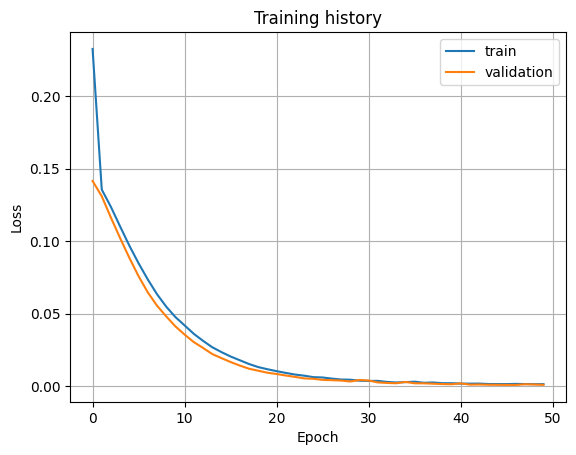

In [28]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

In [29]:
trained_model = ClassificationModel(BACKBONE_NAME)
trained_model = nn.DataParallel(trained_model)
checkpoint = torch.load(ROOT_DIR / f'{SUBMISSION_NAME}.pt', map_location=device)
trained_model.load_state_dict(checkpoint['model_state_dict'])
trained_model.to(device)

trained_model.eval()

preds = None
for batch in tqdm(test_data_loader):
    out = trained_model(
        batch['input_ids'].to(device),
        batch['attention_mask'].to(device),
        batch['token_type_ids'].to(device)
    )
    cur = torch.sigmoid(out).cpu().detach().numpy()
    if preds is not None:
        preds = np.append(preds, cur, axis=0)
    else:
        preds = cur

  0%|          | 0/564 [00:00<?, ?it/s]

In [ ]:
thresh = 0.55
write_submission((preds > thresh).astype(np.float32), df_test, f"{str(thresh).replace('.', '_')}_submission.csv")